# Scikit-learn experiments for Spine Moments

This notebook aims to explore and compare various scikit-learn algorithms for estimating spine moments. It also tries to identify the important (most predictive) features in the dataset.

## Imports

In [1]:
# Standard library

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, svm, ensemble
from sklearn import metrics, preprocessing, pipeline, model_selection

# Local
import utils

# matplotlib hackery
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)

## Load and describe dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/SpinePredictions_500task_pilot_1S_06_16_19/S1_lumbar_results.csv")
df_orig.describe()

,Trial_Index,Mass,Distance_L5S1_to_Mass,Pelvis_Moment_X,Pelvis_Moment_Y,Pelvis_Moment_Z,Lumbar_Ang_X,Lumbar_Ang_Y,Lumbar_Ang_Z,single_equiv_force,...,LEFT_THIGH_ANGLE_Z,RIGHT_THIGH_ANGLE_X,RIGHT_THIGH_ANGLE_Y,RIGHT_THIGH_ANGLE_Z,PELVIS_ANGLE_X,PELVIS_ANGLE_Y,PELVIS_ANGLE_Z,TRUNK_ANGLE_X,TRUNK_ANGLE_Y,TRUNK_ANGLE_Z
count,326857.000000,326857.000000,3.134330e+05,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,...,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000,326857.000000
mean,550.901061,13.060650,4.755246e+04,-56.924430,-2.007236,1.801304,0.217289,0.263557,1.556027,1543.119629,...,70.270698,-12.165187,6.565665,-32.334231,23.663262,-0.125566,61.930977,23.590295,-0.173759,26.845149
std,356.596820,7.028454,2.830211e+05,62.666032,24.202408,13.793083,16.232351,6.093049,6.206927,1336.258779,...,150.927731,15.872266,8.735397,164.178904,18.403032,12.942169,156.666012,34.222313,20.524460,165.951000
min,3.000000,0.000000,1.548541e-01,-2449.074219,-2658.472412,-1935.551514,-46.273388,-21.318174,-117.669724,-102073.642578,...,-179.999832,-176.532043,-52.196800,-179.999939,-69.095657,-60.306068,-179.999969,-132.986252,-80.237129,-179.999939
25%,258.000000,5.000000,5.923886e-01,-100.249306,-8.135581,-0.720945,-11.921501,-1.284068,-1.176766,410.167339,...,-139.329865,-23.045811,2.270329,-175.149445,11.938208,-1.212119,-155.526352,-0.752870,-1.551870,-170.745026
50%,516.000000,15.000000,8.052416e-01,-40.261185,-1.552153,1.003200,6.861834,0.511627,0.956144,1207.146545,...,169.074860,-7.986135,5.328621,-165.038147,16.987801,0.940023,170.696182,9.260746,0.602460,153.429443
75%,796.000000,15.000000,9.602046e-01,-3.046010,3.589606,3.666704,12.813206,1.672854,3.752961,2404.484619,...,174.397736,-0.198130,10.838295,166.513733,34.470535,2.225636,177.125229,44.353691,2.648847,177.208542
max,2048.000000,25.000000,1.732050e+06,2482.969971,1812.542114,1284.894043,67.007713,21.390240,44.820938,110511.052734,...,179.999954,171.471024,45.824146,179.999969,77.854538,63.638962,180.000000,165.166153,81.051125,179.999969


## Cleaning the dataset

In [3]:
meta = ["Trial_Name"]
print(f"Meta ({len(meta)}): {meta}")

targets = [
           "Pelvis_Moment_X", 
#           "Pelvis_Moment_Y", 
#           "Pelvis_Moment_Z", 
#           "single_equiv_force", 
#           "poly_force",
]
print(f"Targets ({len(targets)}): {targets}")

features = df_orig.loc[:, "GRF_LeftFoot":].columns.to_list()
print(f"Features ({len(features)}): {features}")

ignored = set(df_orig.columns) - set(meta + features + targets)
print(f"Ignored ({len(ignored)}): {ignored}")

df = df_orig[meta + targets + features].dropna()

print(f"Number of samples: {df.shape[0]} (orig: {df_orig.shape[0]})")
print("Number of trials:", len(df_orig["Trial_Name"].unique()))

df.describe()

Meta (1): ['Trial_Name']
Targets (1): ['Pelvis_Moment_X']
Features (30): ['GRF_LeftFoot', 'GRF_RightFoot', 'LEFT_COP_Y', 'LEFT_COP_X', 'RIGHT_COP_Y', 'RIGHT_COP_X', 'LEFT_FOOT_ANGLE_X', 'LEFT_FOOT_ANGLE_Y', 'LEFT_FOOT_ANGLE_Z', 'RIGHT_FOOT_ANGLE_X', 'RIGHT_FOOT_ANGLE_Y', 'RIGHT_FOOT_ANGLE_Z', 'LEFT_SHANK_ANGLE_X', 'LEFT_SHANK_ANGLE_Y', 'LEFT_SHANK_ANGLE_Z', 'RIGHT_SHANK_ANGLE_X', 'RIGHT_SHANK_ANGLE_Y', 'RIGHT_SHANK_ANGLE_Z', 'LEFT_THIGH_ANGLE_X', 'LEFT_THIGH_ANGLE_Y', 'LEFT_THIGH_ANGLE_Z', 'RIGHT_THIGH_ANGLE_X', 'RIGHT_THIGH_ANGLE_Y', 'RIGHT_THIGH_ANGLE_Z', 'PELVIS_ANGLE_X', 'PELVIS_ANGLE_Y', 'PELVIS_ANGLE_Z', 'TRUNK_ANGLE_X', 'TRUNK_ANGLE_Y', 'TRUNK_ANGLE_Z']
Ignored (13): {'single_equiv_force', 'poly_force', 'Trial_Index', 'Pelvis_Moment_Y', 'Pelvis_Moment_Z', 'Lumbar_Ang_Y', 'Distance_L5S1_to_Mass', 'Type', 'Lumbar_Ang_X', 'Lumbar_Ang_Z', 'Mass', 'Speed', 'Asy'}
Number of samples: 270243 (orig: 326857)
Number of trials: 328


,Pelvis_Moment_X,GRF_LeftFoot,GRF_RightFoot,LEFT_COP_Y,LEFT_COP_X,RIGHT_COP_Y,RIGHT_COP_X,LEFT_FOOT_ANGLE_X,LEFT_FOOT_ANGLE_Y,LEFT_FOOT_ANGLE_Z,...,LEFT_THIGH_ANGLE_Z,RIGHT_THIGH_ANGLE_X,RIGHT_THIGH_ANGLE_Y,RIGHT_THIGH_ANGLE_Z,PELVIS_ANGLE_X,PELVIS_ANGLE_Y,PELVIS_ANGLE_Z,TRUNK_ANGLE_X,TRUNK_ANGLE_Y,TRUNK_ANGLE_Z
count,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,...,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000,270243.000000
mean,-58.271800,351.009611,347.528258,0.064088,-0.005204,0.057847,0.009733,0.548492,1.370145,-154.141032,...,81.973486,-12.176310,6.644688,-41.125864,24.559152,0.233822,72.390124,24.617132,0.325102,33.995458
std,63.146730,139.620909,144.965017,0.039550,0.013432,0.044888,0.013013,4.484311,2.333030,35.924639,...,145.880699,16.623663,8.368830,163.300866,19.254156,12.461257,153.293256,35.521090,20.063828,166.291868
min,-2402.833496,31.049923,7.910173,-0.059850,-0.042518,-0.074452,-0.079393,-54.715187,-28.134977,-179.995941,...,-179.999481,-77.200333,-51.175518,-179.999939,-69.095657,-60.306068,-179.999969,-132.986252,-79.038773,-179.999924
25%,-105.405079,295.304688,277.938736,0.035119,-0.013607,0.025870,0.004911,-1.280319,0.090155,-166.630104,...,-125.412224,-24.244298,2.757124,-175.515869,11.783187,-0.760785,-148.887154,-1.131968,-1.155004,-172.789726
50%,-39.830818,342.664459,330.406830,0.055084,-0.006933,0.047331,0.013250,-0.116041,1.172100,-162.977798,...,170.512375,-6.721057,5.341134,-168.990936,17.011169,0.942613,173.597458,8.193121,0.576318,162.767914
75%,-1.282372,416.826080,417.774841,0.090734,0.000210,0.087186,0.018083,0.962277,2.468837,-159.202362,...,174.795052,0.322184,10.441864,166.473602,37.875759,1.925269,177.474342,50.983488,2.045681,177.649467
max,139.561554,1086.959351,1074.036377,0.541202,0.068788,0.514304,0.046803,63.657337,24.760069,179.993759,...,179.999954,55.367775,45.824146,179.999969,77.854538,50.970524,180.000000,148.291473,68.145386,179.999969


## Understanding trials, find a good train/validation/test split

We are using the _freestyle_ trials as testing data.

In [4]:
is_test = df['Trial_Name'].str.contains("freestyle")
df_test = df[is_test]
df_train = df[~is_test]
print(f"Train: {len(df_train)}, Test: {len(df_test)} ({len(df_test) / len(df):.1%})")


Train: 228306, Test: 41937 (15.5%)


## Simple linear regression

In [5]:
linreg = linear_model.LinearRegression()
linreg.fit(df_train[features], df_train[targets])
mse_linreg = metrics.mean_squared_error(linreg.predict(df_test[features]), df_test[targets])
print(f"MSE(linear regression): {mse_linreg:.2f}")

MSE(linear regression): 205.39


## Ridge regression

In [6]:
ridgereg = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('ridge', linear_model.Ridge())
])
ridgereg.fit(df_train[features], df_train[targets])
mse_ridgereg = metrics.mean_squared_error(ridgereg.predict(df_test[features]), df_test[targets])
print(f"MSE(ridge regression): {mse_ridgereg:.2f}")

MSE(ridge regression): 205.39


### Ridge hyperparameter search

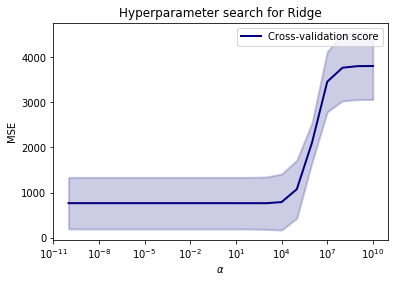

In [7]:
param_range = np.logspace(-10, 10, 21)
cv_train_scores, cv_test_scores = model_selection.validation_curve(
    ridgereg, 
    df_train[features], df_train[targets],
    param_name="ridge__alpha", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

cv_test_scores_mean = -np.mean(cv_test_scores, axis=1)
cv_test_scores_std = np.std(cv_test_scores, axis=1)

plt.title("Hyperparameter search for Ridge")
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
lw = 2
plt.semilogx(param_range, cv_test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, cv_test_scores_mean - cv_test_scores_std,
                 cv_test_scores_mean + cv_test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [8]:
best_alpha = param_range[np.argmin(cv_test_scores_mean)]
print(f"Best alpha for Ridge: {best_alpha}")
ridgereg.set_params(ridge__alpha=best_alpha)
ridgereg.fit(df_train[features], df_train[targets])
mse_ridgereg = metrics.mean_squared_error(ridgereg.predict(df_test[features]), df_test[targets])
print(f"MSE(Best Ridge regression): {mse_ridgereg:.2f}")

Best alpha for Ridge: 1000.0
MSE(Best Ridge regression): 203.52


## Lasso regression

In [9]:
lassoreg = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('lasso', linear_model.Lasso())
])
lassoreg.fit(df_train[features], df_train[targets])
mse_lassoreg = metrics.mean_squared_error(lassoreg.predict(df_test[features]), df_test[targets])
print(f"MSE(Lasso regression): {mse_lassoreg:.2f}")

MSE(Lasso regression): 225.13


### Lasso hyperparameter search

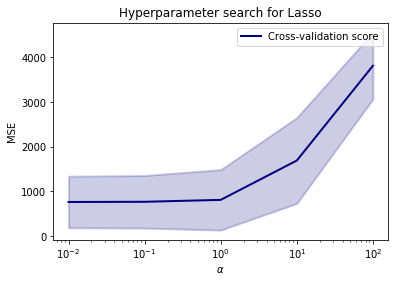

In [10]:
param_range = np.logspace(-2, 2, 5)
cv_train_scores, cv_test_scores = model_selection.validation_curve(
    lassoreg, 
    df_train[features], df_train[targets],
    param_name="lasso__alpha", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

cv_test_scores_mean = -np.mean(cv_test_scores, axis=1)
cv_test_scores_std = np.std(cv_test_scores, axis=1)

plt.title("Hyperparameter search for Lasso")
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
lw = 2
plt.semilogx(param_range, cv_test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, cv_test_scores_mean - cv_test_scores_std,
                 cv_test_scores_mean + cv_test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [11]:
best_alpha = param_range[np.argmin(cv_test_scores_mean)]
print(f"Best alpha for Lasso: {best_alpha}")
lassoreg.set_params(lasso__alpha=best_alpha)
lassoreg.fit(df_train[features], df_train[targets])
mse_lassoreg = metrics.mean_squared_error(lassoreg.predict(df_test[features]), df_test[targets])
print(f"MSE(Best Lasso regression): {mse_lassoreg:.2f}")

Best alpha for Lasso: 0.01
MSE(Best Lasso regression): 204.89


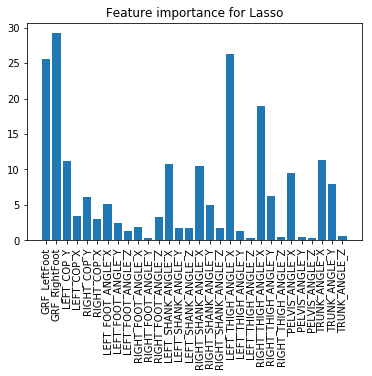

In [12]:
ind = np.arange(len(features))
plt.bar(ind, np.abs(lassoreg.named_steps["lasso"].coef_))
plt.xticks(ind, features, rotation=90)
plt.title("Feature importance for Lasso");

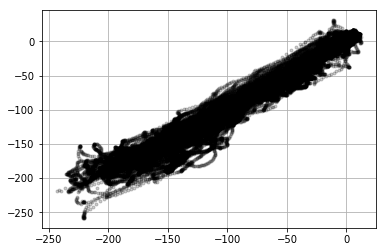

In [13]:
plt.plot(df_test[targets], lassoreg.predict(df_test[features]), 'k.', alpha=.2)
plt.grid()

## SVM regression with Bagging

In [14]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = np.ravel(df_train[targets])
X_test = scaler.transform(df_test[features])
y_test = np.ravel(df_test[targets])

svmreg = ensemble.BaggingRegressor(
    svm.SVR(verbose=True),
    n_estimators=20,
    max_samples=10000,
    n_jobs=-1
)
svmreg.fit(X_train, y_train)
mse_svmreg = metrics.mean_squared_error(svmreg.predict(X_test), y_test)
print(f"MSE(SVM regression): {mse_svmreg:.2f}")

MSE(SVM regression): 543.32


## Random Forrest regression

In [15]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = np.ravel(df_train[targets])
X_test = scaler.transform(df_test[features])
y_test = np.ravel(df_test[targets])

rfreg = ensemble.RandomForestRegressor(
    n_estimators=200,
    n_jobs=-1
)
rfreg.fit(X_train, y_train)
mse_rfreg = metrics.mean_squared_error(rfreg.predict(X_test), y_test)
print(f"MSE(Random Forrest regression): {mse_rfreg:.2f}")

MSE(Random Forrest regression): 612.14


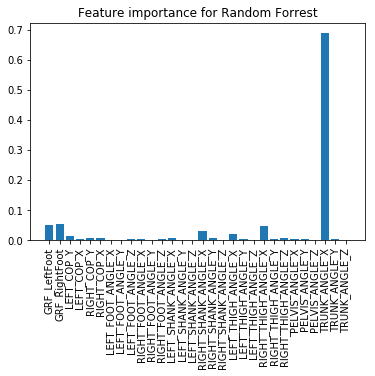

In [16]:
ind = np.arange(len(features))
plt.bar(ind, rfreg.feature_importances_)
plt.xticks(ind, features, rotation=90)
plt.title("Feature importance for Random Forrest");

## Gradient Boosting

In [17]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = np.ravel(df_train[targets])
X_test = scaler.transform(df_test[features])
y_test = np.ravel(df_test[targets])

gboost = ensemble.GradientBoostingRegressor(
    n_estimators=200
)
gboost.fit(X_train, y_train)
mse_gboost = metrics.mean_squared_error(gboost.predict(X_test), y_test)
print(f"MSE(Gradient Boosting regression): {mse_gboost:.2f}")

MSE(Gradient Boosting regression): 149.49


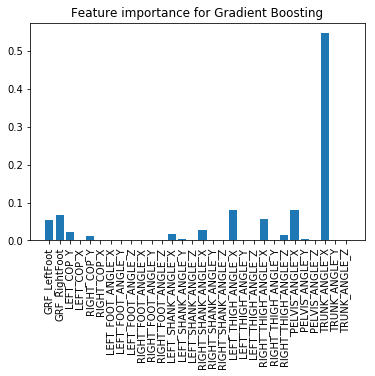

In [18]:
ind = np.arange(len(features))
plt.bar(ind, gboost.feature_importances_)
plt.xticks(ind, features, rotation=90)
plt.title("Feature importance for Gradient Boosting");

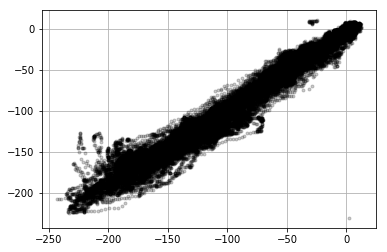

In [19]:
plt.plot(y_test, gboost.predict(X_test), 'k.', alpha=.2)
plt.grid()